## Notebook d'exploration et de traitement des données ##

### Importation et fonctions ###


#### Environnement de travail ####

In [55]:
# Manipulation de données
from collections import Counter
import pandas as pd
import numpy as np

# NLP
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# DataViz
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Project modules
from config.paths import DATA_DIR

In [56]:
# Chargement des dictionnaires NLP de NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gaspardhurez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gaspardhurez/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gaspardhurez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gaspardhurez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Importation des données ###

In [57]:
data = pd.read_csv(f'{DATA_DIR}/bronze/QueryResults.csv')
raw_data = data

In [58]:
data.head()

Title  \
0         How to convert Decimal to Double in C#?   
1                   Calculate relative time in C#   
2                     Determine a user's timezone   
3  What is the fastest way to get the value of π?   
4      How to use the C socket API in C++ on z/OS   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>Given a specific <code>DateTime</code> valu...   
2  <p>Is there a standard way for a web server to...   
3  <p>I'm looking for the fastest way to obtain t...   
4  <p>I'm having issues getting the C sockets API...   

                                                Tags  Id  Score  ViewCount  \
0  <c#><floating-point><type-conversion><double><...   4    810      78143   
1  <c#><datetime><time><datediff><relative-time-s...  11   1656     203728   
2  <html><browser><timezone><user-agent><timezone...  13    721     311524   
3  <performance><algorithm><language-agnostic><un...  19    353      71150   
4                  <c++><c><sockets><mainframe><zos>  25    176      16560   

   FavoriteCount  AnswerCount  
0            NaN           13  
1            NaN           42  
2            NaN           27  
3            NaN           23  
4            NaN            9

#### Définition des fonctions ####

In [59]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [60]:
def normalize_text(text):
    return text.lower()

In [61]:
def tokenize_lemmatize_remove_stopwords(text):

    # Tokenisation
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)


    # Suppression des stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    custom_stopwords = {"use", "using", "like", "one", "value"}
    stop_words.update(custom_stopwords)
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Suppression des chiffres/nombres
    tokens = [token for token in tokens if not token.isdigit()]

    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [62]:
def format_tags(text):
    tags = re.findall(r'<(.*?)>', text)
    return ','.join(tags)

In [63]:
def display_token_info(corpus):
    print(f'Le corpus contient {len(corpus)} tokens')

    unique_tokens = set(corpus.split())
    print(f"Le corpus contient {len(unique_tokens)} tokens uniques")

    print(f"Occurences moyennes par token: {len(corpus) / len(unique_tokens)}")

In [64]:
def plot_most_popular_tokens(corpus):
    token_counts = Counter(corpus.split())
    top_tokens = token_counts.most_common(20)
    tokens, counts = zip(*top_tokens)

    fig = px.bar(x=counts, y=tokens, orientation='h', title='20 tokens les plus populaires')
    fig.update_layout(xaxis_title='Count', yaxis_title='Token')
    fig.show()

In [65]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Nettoyage des données ###

#### Analyse préliminaire ####

##### Structure et aperçu des données ######

In [66]:
data.sample(5)

Title  \
35136  JQGrid tree - passing additional parameters wh...   
14879                    OpenThread() Returns NULL Win32   
32978  get FileChannel without using java.io.* (use p...   
5506   ASP.NET Forms Authentication using third party...   
16482  How to simultaneously update an Access databas...   

                                                    Body  \
35136  <p>I have a JQGRid tree. It loads data click b...   
14879  <p>I feel like there is an obvious answer to t...   
32978  <p>Recently I got a comment to this <a href="h...   
5506   <p>I have a website where I currently use ASP....   
16482  <p>I have imported an Access database into my ...   

                                                    Tags       Id  Score  \
35136       <javascript><jquery><ajax><jqgrid><treegrid>  2138851      0   
14879  <c++><windows><multithreading><winapi><visual-...  1069860      2   
32978                <java><file-io><copy><nio><channel>  2036921      4   
5506   <jquery><wcf><json><asp.net-membership><mootools>   484345      0   
16482  <c#><ms-access><dataset><connection-string><ol...  1163768      0   

       ViewCount  FavoriteCount  AnswerCount  
35136       2334            NaN            2  
14879       7968            NaN            1  
32978       5063            NaN            2  
5506         727            NaN            2  
16482       3197            NaN            1

In [67]:
data.shape

(50000, 8)

In [68]:
data.dtypes

Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [69]:
data.describe(include='object')

Title  \
count                                        50000   
unique                                       49997   
top     The ProxyFactoryFactory was not configured   
freq                                             2   

                                                     Body  \
count                                               50000   
unique                                              50000   
top     <p>I want to assign the decimal variable &quot...   
freq                                                    1   

                                                     Tags  
count                                               50000  
unique                                              49140  
top     <sql><sql-server><sql-server-2005><t-sql><stor...  
freq                                                   22

In [70]:
data.describe()

Id         Score     ViewCount  FavoriteCount   AnswerCount
count  5.000000e+04  50000.000000  5.000000e+04            0.0  50000.000000
mean   1.564775e+06     25.334080  2.363893e+04            NaN      3.600180
std    7.714602e+05    217.162466  1.495958e+05            NaN      3.991226
min    4.000000e+00     -6.000000  2.900000e+01            NaN      1.000000
25%    9.314418e+05      1.000000  1.041000e+03            NaN      2.000000
50%    1.616512e+06      2.000000  2.649000e+03            NaN      3.000000
75%    2.242424e+06      7.000000  8.294000e+03            NaN      4.000000
max    2.780304e+06  20374.000000  1.177092e+07            NaN    130.000000

##### Valeurs manquantes #####

In [71]:
data.isna().sum()

Title                0
Body                 0
Tags                 0
Id                   0
Score                0
ViewCount            0
FavoriteCount    50000
AnswerCount          0
dtype: int64

In [72]:
data.isna().mean()

Title            0.0
Body             0.0
Tags             0.0
Id               0.0
Score            0.0
ViewCount        0.0
FavoriteCount    1.0
AnswerCount      0.0
dtype: float64

##### Valeurs dupliquées #####

In [73]:
data.duplicated().sum()

0

In [74]:
data.nunique()

Title            49997
Body             50000
Tags             49140
Id               50000
Score              807
ViewCount        18272
FavoriteCount        0
AnswerCount         66
dtype: int64

In [75]:
duplicates_mask = data.duplicated(subset=['Title'], keep=0)

In [76]:
data[duplicates_mask]

Title  \
13196       The ProxyFactoryFactory was not configured   
17297       The ProxyFactoryFactory was not configured   
29378         You are not authorized to view this page   
29589         You are not authorized to view this page   
38153  JQuery BlockUI with UpdatePanel Viewstate Issue   
38160  JQuery BlockUI with UpdatePanel Viewstate Issue   

                                                    Body  \
13196  <p>Considering this example as a base example,...   
17297  <p>We have recently upgraded our windows forms...   
29378  <p>I am getting the following error while brow...   
29589  <p>I am getting the following error while brow...   
38153  <p>I have an update panel within a div that I ...   
38160  <p>I am using BlockUI to show a modal. Within ...   

                                                    Tags       Id  Score  \
13196  <asp.net><nhibernate><nhibernate-mapping><nhib...   973979     11   
17297  <c#><winforms><visual-studio-2008><nhibernate>...  1209106      4   
29378  <asp.net><iis><web-applications><iis-7><web-co...  1848459      1   
29589  <asp.net><iis><deployment><web-config><webserver>  1859539      1   
38153  <asp.net><jquery><updatepanel><viewstate><bloc...  2269585      2   
38160  <asp.net><jquery><updatepanel><viewstate><bloc...  2269797      4   

       ViewCount  FavoriteCount  AnswerCount  
13196      19188            NaN            5  
17297      10423            NaN            4  
29378       2413            NaN            1  
29589       5529            NaN            1  
38153       2526            NaN            2  
38160       3611            NaN            4

In [77]:
for row in data[duplicates_mask].Body:
    print("Body: " + row[0:100])

Body: <p>Considering this example as a base example, I created the application but when I execute this app
Body: <p>We have recently upgraded our windows forms C# project from NHibernate 2.0 to 2.1. We updated our
Body: <p>I am getting the following error while browsing the my webpage </p>

<p>i checked and seen anaymo
Body: <p>I am getting the following error while browsing my asp.net page deployed in IIS</p>

<pre><code>Y
Body: <p>I have an update panel within a div that I modal using the JQuery plugin BlockUI. Inside the Upda
Body: <p>I am using BlockUI to show a modal. Within the blocked modal I have an update panel. Within the u


Il ne semble pas y'avoir de vrais doublons dans ce jeu de données.

##### Valeurs aberrantes #####

In [78]:
data.dtypes

Title             object
Body              object
Tags              object
Id                 int64
Score              int64
ViewCount          int64
FavoriteCount    float64
AnswerCount        int64
dtype: object

In [79]:
numeric_cols = list(data.select_dtypes(include='number').columns)
numeric_cols.remove('Id')
numeric_cols

['Score', 'ViewCount', 'FavoriteCount', 'AnswerCount']

In [80]:
# Distributions des variables numériques
n_rows = 2
n_cols = 2

fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=numeric_cols, )

for i, col in enumerate(numeric_cols):
    row_index = i // n_cols + 1
    col_index = i % n_cols + 1
    fig.add_trace(go.Histogram(x=data[col]), row=row_index, col=col_index)

fig.update_layout(
    height=300 * n_rows, 
    showlegend=False, 
    title='Distribution des variables numériques'
    )
fig.show()

In [81]:
data.sort_values(by='ViewCount', ascending=False).head(5)

Title  \
32323  How do I delete a Git branch locally and remot...   
15867  How do I force "git pull" to overwrite local f...   
49657  How do I push a new local branch to a remote G...   
39653       How do I UPDATE from a SELECT in SQL Server?   
715    How do I execute a program or call a system co...   

                                                    Body  \
32323  <p>Failed Attempts to Delete a Remote Branch:<...   
15867  <p>How do I force an overwrite of local files ...   
49657  <p>How do I:</p>\n<ol>\n<li><p>Create a local ...   
39653  <p>In <strong>SQL Server</strong>, it is possi...   
715    <p>How do I call an external command within Py...   

                                                    Tags       Id  Score  \
32323  <git><version-control><git-branch><git-push><g...  2003505  20374   
15867  <git><version-control><overwrite><git-pull><gi...  1125968   9730   
49657  <git><repository><git-branch><git-push><git-re...  2765421   5698   
39653          <sql><sql-server><t-sql><sql-update><dml>  2334712   4287   
715       <python><shell><terminal><subprocess><command>    89228   6176   

       ViewCount  FavoriteCount  AnswerCount  
32323   11770919            NaN           41  
15867    8729352            NaN           54  
49657    6166413            NaN           20  
39653    5390183            NaN           40  
715      4842772            NaN           66

Certains posts peuvent clairement être qualifiés d'outliers au niveau des métriques d'engagement (vues, réponses).  
Pour autant, après inspection de certains des posts les plus vus, ces valeurs ne semblent pas forcément impossibles sur un site comme StackOverflow.

#### Nettoyage ####

##### Sélection des colonnes #####

- La variable FavoriteCount ne contient que des valeurs nulles; il convient de la supprimer.
- La colonne Id n'aura pas d'intérêt pour ce projet d'analyse textuelle.
- Je garde pour l'instant les métriques d'engagement, qui permettront potentiellement une analyse multivariée intéressante.

In [82]:
data.drop(columns=['FavoriteCount', 'Id'], inplace=True)

In [83]:
data.head()

Title  \
0         How to convert Decimal to Double in C#?   
1                   Calculate relative time in C#   
2                     Determine a user's timezone   
3  What is the fastest way to get the value of π?   
4      How to use the C socket API in C++ on z/OS   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>Given a specific <code>DateTime</code> valu...   
2  <p>Is there a standard way for a web server to...   
3  <p>I'm looking for the fastest way to obtain t...   
4  <p>I'm having issues getting the C sockets API...   

                                                Tags  Score  ViewCount  \
0  <c#><floating-point><type-conversion><double><...    810      78143   
1  <c#><datetime><time><datediff><relative-time-s...   1656     203728   
2  <html><browser><timezone><user-agent><timezone...    721     311524   
3  <performance><algorithm><language-agnostic><un...    353      71150   
4                  <c++><c><sockets><mainframe><zos>    176      16560   

   AnswerCount  
0           13  
1           42  
2           27  
3           23  
4            9

##### Typage des données #####

Toutes les variables ont le bon type de données.

##### Valeurs manquantes #####

Il n'y a plus de colonne contenant des valeurs manquantes.

##### Valeurs dupliquées #####

Il n'y a pas de valeurs dupliquées dans ce jeu de données.

##### Valeurs aberrantes #####

Au vu du contexte du projet, il n'y a peu/pas d'intérêt à supprimer les valeurs extrêmes observées, ou à transformer les distributions.

### Traitement des données textuelles ###

Il faut maintenant nettoyer et formater les données textuelles pour faciliter leur analyse et leur exploitation lors de la modélisation.

#### Suppression des balises HTML ####

Le corps de texte des questions est intégré dans des balises HTML `<p>`. Je vais les supprimer.

In [84]:
data.Body[0]

'<p>I want to assign the decimal variable &quot;trans&quot; to the double variable &quot;this.Opacity&quot;.</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the app it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type decimal to double</p>\n</blockquote>\n'

In [85]:
data['clean_body'] = data.Body.apply(remove_html_tags)

In [86]:
data.clean_body[0]

'I want to assign the decimal variable "trans" to the double variable "this.Opacity".\ndecimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n\nWhen I build the app it gives the following error:\n\nCannot implicitly convert type decimal to double\n\n'

#### Formatage des tags ####

Les tags sont séparés par des chevrons; je les remplace par une virgule séparatrice, après m'être assuré qu'il n'y a pas de virgule dans le texte de base.

In [87]:
data.Tags.str.cat(sep=' ').count(',')

0

In [88]:
data['processed_tags'] = data.Tags.apply(format_tags)

In [89]:
data.processed_tags

0        c#,floating-point,type-conversion,double,decimal
1            c#,datetime,time,datediff,relative-time-span
2        html,browser,timezone,user-agent,timezone-offset
3         performance,algorithm,language-agnostic,unix,pi
4                             c++,c,sockets,mainframe,zos
                               ...                       
49995          javascript,jquery,html,css,jquery-validate
49996           python,performance,profiling,gis,cprofile
49997     c#,wpf,silverlight,silverlight-3.0,media-player
49998                          c++,c,windows,registry,wmi
49999                    c++,qt,qt4,signals,signals-slots
Name: processed_tags, Length: 50000, dtype: object

#### Normalisation ####

Je normalise le texte en mettant le titre et le corps de texte en minuscules.

In [90]:
data['body_normalized'] = data.clean_body.apply(normalize_text)
data['title_normalized'] = data.Title.apply(normalize_text)

In [91]:
data.head()

Title  \
0         How to convert Decimal to Double in C#?   
1                   Calculate relative time in C#   
2                     Determine a user's timezone   
3  What is the fastest way to get the value of π?   
4      How to use the C socket API in C++ on z/OS   

                                                Body  \
0  <p>I want to assign the decimal variable &quot...   
1  <p>Given a specific <code>DateTime</code> valu...   
2  <p>Is there a standard way for a web server to...   
3  <p>I'm looking for the fastest way to obtain t...   
4  <p>I'm having issues getting the C sockets API...   

                                                Tags  Score  ViewCount  \
0  <c#><floating-point><type-conversion><double><...    810      78143   
1  <c#><datetime><time><datediff><relative-time-s...   1656     203728   
2  <html><browser><timezone><user-agent><timezone...    721     311524   
3  <performance><algorithm><language-agnostic><un...    353      71150   
4                  <c++><c><sockets><mainframe><zos>    176      16560   

   AnswerCount                                         clean_body  \
0           13  I want to assign the decimal variable "trans" ...   
1           42  Given a specific DateTime value, how do I disp...   
2           27  Is there a standard way for a web server to be...   
3           23  I'm looking for the fastest way to obtain the ...   
4            9  I'm having issues getting the C sockets API to...   

                                     processed_tags  \
0  c#,floating-point,type-conversion,double,decimal   
1      c#,datetime,time,datediff,relative-time-span   
2  html,browser,timezone,user-agent,timezone-offset   
3   performance,algorithm,language-agnostic,unix,pi   
4                       c++,c,sockets,mainframe,zos   

                                     body_normalized  \
0  i want to assign the decimal variable "trans" ...   
1  given a specific datetime value, how do i disp...   
2  is there a standard way for a web server to be...   
3  i'm looking for the fastest way to obtain the ...   
4  i'm having issues getting the c sockets api to...   

                                 title_normalized  
0         how to convert decimal to double in c#?  
1                   calculate relative time in c#  
2                     determine a user's timezone  
3  what is the fastest way to get the value of π?  
4      how to use the c socket api in c++ on z/os

#### Tokenization et lemmatisation ####

Je vais maintenant tokeniser et lemmatiser mes données textuelles pour faciliter leur manipulation ultérieure.

In [92]:
data['processed_title_tokens'] = data.title_normalized.apply(tokenize_lemmatize_remove_stopwords)
data['processed_body_tokens'] = data.body_normalized.apply(tokenize_lemmatize_remove_stopwords)

In [93]:
data[['processed_title_tokens', 'processed_body_tokens']].head()

processed_title_tokens  \
0   [convert, decimal, double, c]   
1  [calculate, relative, time, c]   
2     [determine, user, timezone]   
3          [fastest, way, get, π]   
4       [c, socket, api, c, z, o]   

                               processed_body_tokens  
0  [want, assign, decimal, variable, trans, doubl...  
1  [given, specific, datetime, display, relative,...  
2  [standard, way, web, server, able, determine, ...  
3  [looking, fastest, way, obtain, π, personal, c...  
4  [issue, getting, c, socket, api, work, properl...

#### Constitution des corpus ####

Je sélectionne d'abord les colonnes de texte traité.

In [94]:
relevant_cols = ['processed_title_tokens', 'processed_body_tokens', 'processed_tags']

In [95]:
data = data[relevant_cols]

Je stocke mes corpus de texte dans des variables, pour plus de praticité.

In [96]:
corpus_titles = ' '.join(data.processed_title_tokens.apply(lambda tokens: ' '.join(tokens)))
corpus_bodies = ' '.join(data.processed_body_tokens.apply(lambda tokens: ' '.join(tokens)))
corpus_tags = data.processed_tags.str.cat(sep=' ').replace(",", " ")

J'exporte le jeu de données pour pouvoir réaliser les prochaines opérations (extraction de features, modélisation).

In [97]:
data.to_json(f'{DATA_DIR}/silver/processed_data.json')

In [98]:
data.processed_title_tokens.apply(lambda tokens: ' '.join(tokens))

0                                 convert decimal double c
1                                calculate relative time c
2                                  determine user timezone
3                                        fastest way get π
4                                       c socket api c z o
                               ...                        
49995                 jquery validation class instead name
49996    python script spending time missing time cprof...
49997    set playlist index mediaplayer expressionmedia...
49998      deny access run certain installed software user
49999                              track emitted signal qt
Name: processed_title_tokens, Length: 50000, dtype: object

In [99]:
data

processed_title_tokens  \
0                          [convert, decimal, double, c]   
1                         [calculate, relative, time, c]   
2                            [determine, user, timezone]   
3                                 [fastest, way, get, π]   
4                              [c, socket, api, c, z, o]   
...                                                  ...   
49995         [jquery, validation, class, instead, name]   
49996  [python, script, spending, time, missing, time...   
49997  [set, playlist, index, mediaplayer, expression...   
49998  [deny, access, run, certain, installed, softwa...   
49999                       [track, emitted, signal, qt]   

                                   processed_body_tokens  \
0      [want, assign, decimal, variable, trans, doubl...   
1      [given, specific, datetime, display, relative,...   
2      [standard, way, web, server, able, determine, ...   
3      [looking, fastest, way, obtain, π, personal, c...   
4      [issue, getting, c, socket, api, work, properl...   
...                                                  ...   
49995  [validate, form, jquery, validate, plugin, una...   
49996  [attempting, profile, long, running, python, s...   
49997  [mediaplayer, control, xaml, page, custommedia...   
49998  [list, installed, software, obtained, wmi, cla...   
49999  [way, observe, signal, emitted, p, course, wri...   

                                         processed_tags  
0      c#,floating-point,type-conversion,double,decimal  
1          c#,datetime,time,datediff,relative-time-span  
2      html,browser,timezone,user-agent,timezone-offset  
3       performance,algorithm,language-agnostic,unix,pi  
4                           c++,c,sockets,mainframe,zos  
...                                                 ...  
49995        javascript,jquery,html,css,jquery-validate  
49996         python,performance,profiling,gis,cprofile  
49997   c#,wpf,silverlight,silverlight-3.0,media-player  
49998                        c++,c,windows,registry,wmi  
49999                  c++,qt,qt4,signals,signals-slots  

[50000 rows x 3 columns]

### Exploration du vocabulaire ### 

#### Analyse du corpus de titres ####

In [100]:
display_token_info(corpus_titles)

Le corpus contient 2090398 tokens
Le corpus contient 18641 tokens uniques
Occurences moyennes par token: 112.13979936698675


In [101]:
plot_most_popular_tokens(corpus_titles)

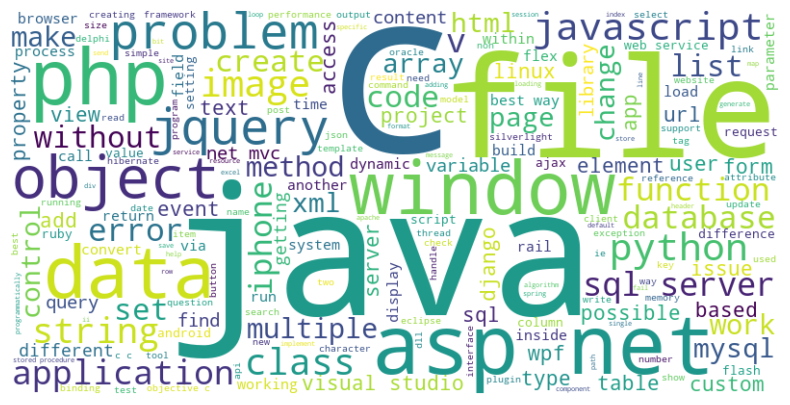

In [102]:
generate_wordcloud(corpus_titles)

#### Analyse du corpus de corps de texte ####

In [103]:
display_token_info(corpus_bodies)

Le corpus contient 33612675 tokens
Le corpus contient 184509 tokens uniques
Occurences moyennes par token: 182.17363380648098


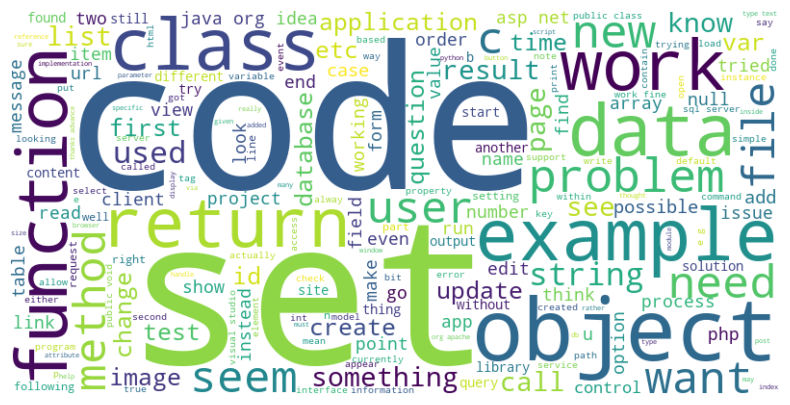

In [104]:
generate_wordcloud(corpus_bodies)

In [105]:
plot_most_popular_tokens(corpus_bodies)

#### Analyse du corpus de tags ####

In [106]:
display_token_info(corpus_tags)

Le corpus contient 2222568 tokens
Le corpus contient 13347 tokens uniques
Occurences moyennes par token: 166.52191503708698


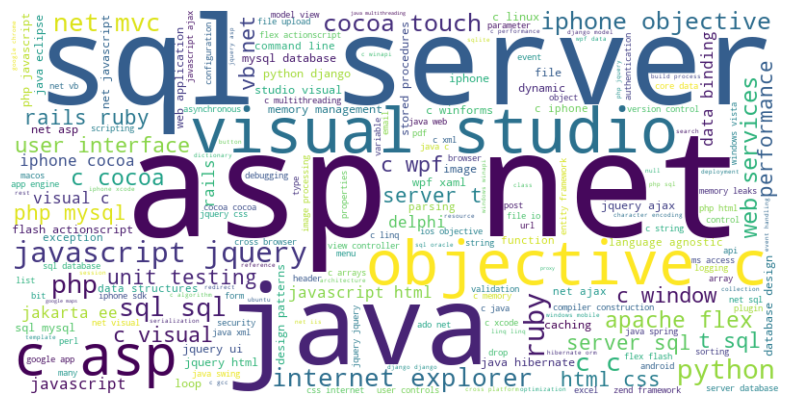

In [107]:
generate_wordcloud(corpus_tags)

In [108]:
plot_most_popular_tokens(corpus_tags)